#### Importação das bibliotecas

In [107]:
!python -c 'import keras; print(keras.__version__)'

2021-08-02 01:19:14.367367: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2.4.3


In [106]:
!pip install keras==2.4.3

  Attempting uninstall: keras
    Found existing installation: keras 2.6.0rc1
    Uninstalling keras-2.6.0rc1:
      Successfully uninstalled keras-2.6.0rc1


In [91]:
import numpy as np
import scipy.misc
import os
import matplotlib.pyplot as plt
import collections

from PIL import Image
from keras.utils import np_utils
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger, LambdaCallback
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold

from keras.preprocessing import image

import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve

import time

from tensorflow.keras.layers import Input

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import auc
from itertools import cycle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score

In [92]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

#### Definição de parametros

In [ ]:
img_size = 224

batch_size = 32

K = 10
l_r=0.001
steps = 245

dropout = 0.5
bn_momentum = 0.9
l2 = 0.00001

path='C:\\Users\\Gledson\\Documents\\Projetos\\TCC\\Dataset_reduzido'

#### Carregamento da base de dados

In [ ]:
def load_dataset(base_dir):
    
    shuffle=True
    X = []
    Y = []
    processed_image_count = 0
    classes = 0
    for root, subdirs, files in os.walk(base_dir):
        if subdirs:
            classes = subdirs
        for filename in files:
            file_path = os.path.join(root, filename)
            assert file_path.startswith(base_dir)
            suffix = file_path[len(base_dir):]
            suffix = suffix.lstrip(os.sep)
            label = suffix.split(os.sep)[0]
            
            img = Image.open(file_path)
            img = img.convert('RGB')
            img = np.asarray(img)

            height, width, chan = img.shape
            assert chan == 3
            img = scipy.misc.imresize(img, size=(img_size, img_size), interp='bilinear')
            
            img = img/255.
            
            X.append(img)
            Y.append(classes.index(label))
            
            processed_image_count += 1
            
    print ("Processed: %d images" % (processed_image_count))
    
    X = np.array(X, dtype='float32')
    Y = np.array(Y)
    
    print("Shuffle: " + str(shuffle))
    if shuffle:
        np.random.seed(2)
        perm = np.random.permutation(len(Y))
        X = X[perm]
        Y = Y[perm]
        
    return X, Y

In [ ]:
X, Y = load_dataset(path)

C:\Users\Gledson\Anaconda3\envs\cnn\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Processed: 30 images
Shuffle: True


#### Importanto modelos prontas

#### VGG16

In [62]:
def model_vgg16():
    vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)), input_shape=(224, 224,3))

    vgg_model.trainable = False
    
    x = vgg_model.output
    
    x = GlobalAveragePooling2D()(x)
  
    x = Dense(1024, activation='relu')(x)

    x = Dense(512, activation='relu')(x)
    
    x = Dense(256, activation='relu')(x)

    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=vgg_model.input, outputs=predictions)
  
    model.compile(optimizer=Adam(lr=0.00001, decay=0.0001), loss='categorical_crossentropy', 
    				  metrics=[
				           tf.keras.metrics.CategoricalAccuracy(),
				           tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision(),
                   tf.keras.metrics.PrecisionAtRecal(),
				           tf.keras.metrics.AUC()
				          ]
				  )
    
    return model

#### Xception

In [85]:
def model_xception():
    xception_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)), input_shape=(299, 299,3))

    xception_model.trainable = False
	
    x = xception_model.output
    
    x = GlobalAveragePooling2D()(x)
  
    x = Dense(1024, activation='relu')(x)

    x = Dense(512, activation='relu')(x)
    
    x = Dense(256, activation='relu')(x)

    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=xception_model.input, outputs=predictions)
  
    model.compile(optimizer=Adam(lr=0.00001, decay=0.0001), loss='categorical_crossentropy', 
    				  metrics=[
				           tf.keras.metrics.CategoricalAccuracy(),
				           tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision(),
                   tf.keras.metrics.PrecisionAtRecal(),
				           tf.keras.metrics.AUC()
				          ]
				  )
    
    return model

## Inception

In [112]:
def model_inseption():
    InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)), input_shape=(299, 299, 3))

    InceptionV3_model.trainable = False
	
    x = InceptionV3_model.output
    
    x = GlobalAveragePooling2D()(x)
  
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs=InceptionV3_model.input, outputs=predictions)
  
    model.compile(optimizer=Adam(lr=0.00001, decay=0.0001), loss='categorical_crossentropy', 
    				  metrics=[
				           tf.keras.metrics.CategoricalAccuracy(),
				           tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision(),
				           tf.keras.metrics.AUC()
				          ]
				  )
    
    return model

In [113]:
model_inseption()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Definição dos parametros para Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

X_generator = []
Y_generator = []

generator = datagen.flow(X, Y, batch_size=batch_size, shuffle=False)

for x in range(0, steps):
    aux = generator.next()
    
    for x in aux[0]:
        X_generator.append(x)
    for y in aux[1]:
        Y_generator.append(y)

len(X_generator)

4900

In [ ]:
x_aux = X[0:500]
y_aux = Y[0:500]

#### Declaração da Arquitetura para Extração das Features

In [ ]:
model = model_vgg16()

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 218, 218, 32)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 218, 218, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 103, 103, 32)      50208     
_________________________________________________________________
batch_normalization_2 (Batch (None, 103, 103, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 103, 103, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 99, 64)        51264     
__________

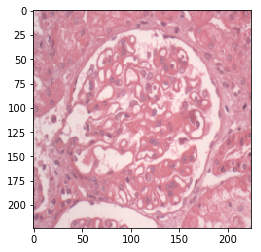

In [ ]:
plt.imshow(image.array_to_img(X[2]))

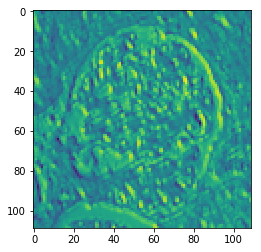

In [ ]:
plt.imshow(features[2, :, :, 1])

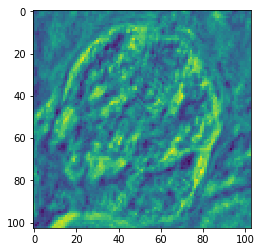

In [ ]:
plt.imshow(features[2, :, :, 1])

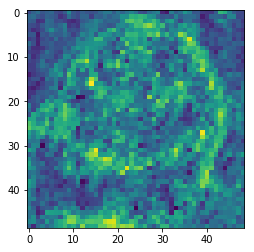

In [ ]:
plt.imshow(features[2, :, :, 1])

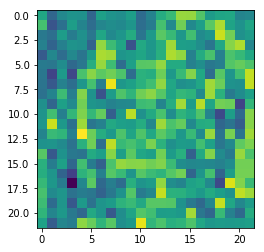

In [ ]:
plt.imshow(features[2, :, :, 2])

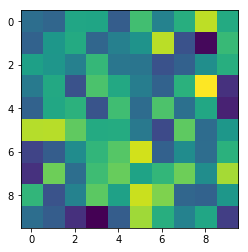

In [ ]:
plt.imshow(features[2, :, :, 1])

#### Redução de dimencionalidade das imagens para auxiliar na visualização da distribuição das classes

In [ ]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(x)
X_embedded.shape

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 2.173s...
[t-SNE] Computed neighbors for 500 samples in 54.832s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.861239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.524040
[t-SNE] KL divergence after 300 iterations: 0.791963


(500, 2)

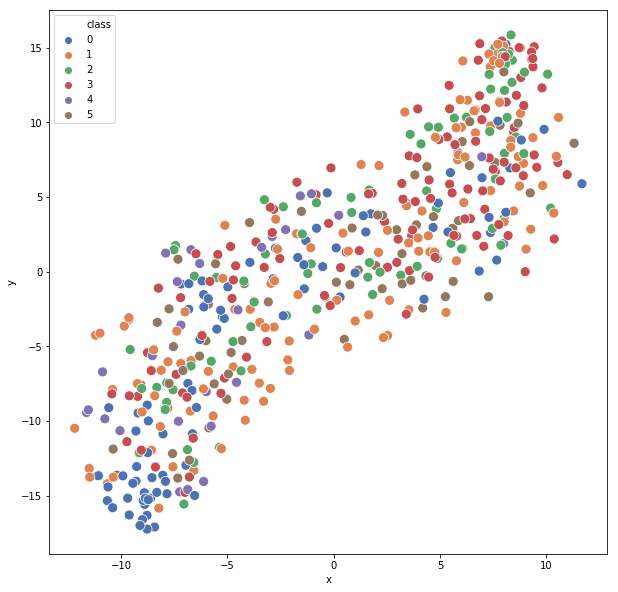

In [ ]:
tsne_data = pd.DataFrame(columns=['x', 'y', 'class'])

tsne_data['x'] = X_embedded[:,0]
tsne_data['y'] = X_embedded[:,1]
tsne_data['class'] = y

plt.figure(figsize=(10,10))
sns.scatterplot(
    x='x', y='y',
    hue='class',
    palette="deep",
    marker='o',
    s=100,
    data=tsne_data,
)

In [ ]:
X_embedded_3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300).fit_transform(x)
X_embedded_3.shape

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 2.073s...
[t-SNE] Computed neighbors for 500 samples in 55.176s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.861239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.679169
[t-SNE] KL divergence after 300 iterations: 3.632804


(500, 3)

Text(0.5, 0, 'Z Label')

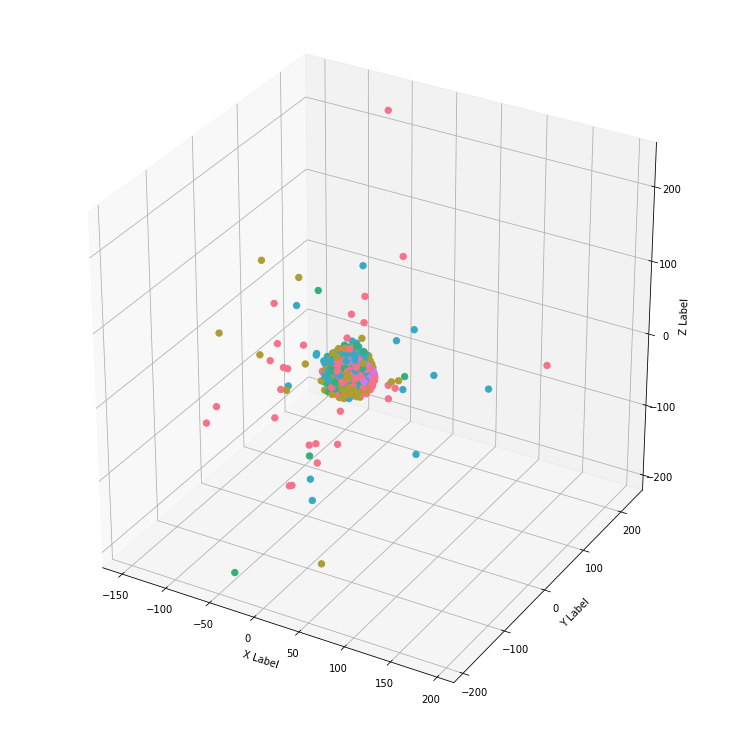

In [ ]:
tsne_data3 = pd.DataFrame(columns=['x', 'y', 'z', 'class'])

tsne_data3['x'] = X_embedded_3[:,0]
tsne_data3['y'] = X_embedded_3[:,1]
tsne_data3['z'] = X_embedded_3[:,1]
tsne_data3['class'] = y

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(tsne_data3['x'], tsne_data3['y'], tsne_data3['z'], s=40, c=tsne_data3['class'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


In [ ]:
features_dataset = pd.DataFrame(data=features)
features_dataset.insert(column="class", value=y, loc=0)

features_dataset.to_csv(r'C:\\Users\\Gledson\\Documents\\UEFS\\TCC\\DataSets\\features_aug_arc4.csv', index = False)

#### Separação do dataset entre treinamento e teste

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

In [ ]:
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state = 2)

#### Definição de métricas e parametros de treinamento

In [ ]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'Time to Train'])
metrics

""
accuracy
precision
recall
Time to Train


In [ ]:
param_grids = [param_grid_knn, param_grid_svm, param_grid_dt, param_grid_rf]

#### Treinamento e avaliação do classificador

In [ ]:
K = 10
l_r=0.001

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state = 2)

for index, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
    print('_________________________________________________________________________\n')
    print ("Training on fold " + str(index+1) + "/"+str(K)+"...")
    # Generate batches from indices
    xtrain, xval = X[train_indices], X[val_indices]
    ytrain, yval = Y[train_indices], Y[val_indices]
    
    ytrain = np_utils.to_categorical(ytrain, 4)
    
    unique, counts = np.unique(yval, return_counts=True)
    print(dict(zip(unique, counts)))
    
    #print(train_indices)
    #print(val_indices)
    
    yval = np_utils.to_categorical(yval, 4)
    
    print('Training set: ' + str(xtrain.shape[0]) + ' images')
    print('Test set: ' + str(xval.shape[0]) + ' images')
    print('')
    
    
    #print(yval)
    
    steps = len(xtrain)*3
    
    #steps = 2
    nb_test_samples = len(xval)
    
    # Clear model, and create it
    model = None
    model = features_extractor_vgg()
           
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=l_r, decay=1e-6), #antes sgd, adam, rmsprop
                  metrics=['accuracy'])
    
    datagen.fit(xtrain)
    
    filepath="bestModel" + str(index+1)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
    callbacks_list = [checkpoint]
    history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    epochs=200,
                    steps_per_epoch=steps,
                    validation_data=(xval, yval),
                    callbacks=callbacks_list)